1. Background of Project
2. Hypotheses
3. Summary of Findings and Insights
4. Data Acquisition and Prep
5. Exploratory Data Analysis
6. Feature Engineering
7. Modeling
8. Evaluation

Notes:
- Image use footnote
    - PBS KIDS and the PBS KIDS Logo are registered trademarks of PBS. Used with permission. The contents of PBS KIDS Measure Up! were developed under a grant from the Department of Education. However, those contents do not necessarily represent the policy of the Department of Education, and you should not assume endorsement by the Federal Government. The app is funded by a Ready To Learn grant (PR/AWARD No. U295A150003, CFDA No. 84.295A) provided by the Department of Education to the Corporation for Public Broadcasting.

# Child Learning and Development with PBS KIDS Measure Up! App

![title](mu_image.jpeg)

## I. BACKGROUND

### MEASURE UP! APP  
The PBS KIDS Measure Up! app is designed for children ages 3-5 to develop their comprehension of early STEM concepts. The app takes users on an adventure through three worlds: 
   - **Magma Peak** focuses on capacity and displacement
   - **Crystal Caves** focus is about weight
   - **Treetop City** teaches the concepts of length and height.

### 2019 KAGGLE DATA SCIENCE BOWL COMPETITION PRESENTED BY PBS KIDS & BOOZ ALLEN HAMILTON
This year's competition is focused on early childhood education through multimedia learning. Anonymized Measure Up! gameplay data was provided by PBS KIDS. The end product of each submission is to provide a model that predicts the accuracy group of users.

Accuracy group is based on the number of attempts a user makes until s/he completes the "challenge" (a.k.a. assessment). Based on user's performance on each completed assessment, an accuracy group is assigned:
 - 3 - Successfully completed the assessment on 1 attempt
 - 2 - Completed assessment on 2 attempts
 - 1 - Completed assessment on 3 attempts
 - 0 - Completed assessment on more than 3 attempts

The model will help PBS KIDS to improve game design and to discover relationships on game engagement and learning processes.

### THE PROJECT
The project is inspired by 2019's Kaggle Data Science Bowl. By analyzing data publicly provided by PBS KIDS on Kaggle, our team has sought to identify and understand drivers of children’s success on assessments (a.k.a. "challenges") in the app. The insights inform teachers and parents on how well using the different activities in the application prepare 3-5-year old children for the application’s final assessments.

A presentation documenting our findings and recommendations is delivered on Jan 30, 2020.

### PROBLEM STATEMENTS & HYPOTHESES:

**Problem 1:** What are the drivers of users assessment accuracy?  
**Hypothesis:** Users will show improvement with more engagement.
  
**Problem 2:** Is there a certain path that better prepare users in assessments - with the two paths being, linear progression and random (choose activities at their own will)  
**Hypothesis:** There is no difference in the performance between users who followed a linear progression and those who had random learning path.

> Linear Progression and their corresponding in-game activities are as follows:  
**Exposure** (video clip) → **Exploration** (activity) → **Practice** (game) → **Demonstration** (assessment)

### SUMMARY OF FINDINGS AND INSIGHTS

### CONCLUSION AND RECOMMENDATION




---

## II. MODULES & LIBRARIES

In [663]:
import pandas as pd
import numpy as np

#viz
import matplotlib.pyplot as plt
import seaborn as sns

#feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV

#modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

---
## III. DATA ACQUISITION & PREP

---
## IV. EXPLORATORY DATA ANALYSIS 

### Feature Selection

In [664]:
big = pd.read_csv("train_maybe_final.csv")

In [665]:
big.installation_id.nunique()

3485

In [666]:
big.head()

,Unnamed: 0,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,num_correct,num_incorrect,accuracy,accuracy_group,date,hour,weekday
0,0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,NaN,NaN,NaN,NaN,2019-08-06,4,Tuesday
1,1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN,NaN,NaN,NaN,2019-08-06,4,Tuesday
2,2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,2019-08-06,4,Tuesday
3,3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,2019-08-06,4,Tuesday
4,4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN,NaN,NaN,NaN,2019-08-06,4,Tuesday


In [667]:
assessment = big[big.type == "Assessment"]

#### MAX CEILING

In [668]:
mc = assessment.groupby(["installation_id","game_session"])[["accuracy"]].max().sort_values(by=["installation_id","accuracy"],ascending=False).reset_index()
mc = mc.drop_duplicates(subset="installation_id",keep="first")

max_ceiling = mc[["installation_id","accuracy"]].set_index("installation_id").rename(columns={"accuracy":"max_ceiling"})

In [669]:
max_ceiling.shape

(2496, 1)

#### LOWEST POSSIBLE SCORE

In [670]:
ls = assessment.groupby(["installation_id","game_session"])[["accuracy"]].min().sort_values(by=["installation_id","accuracy"],ascending=True).reset_index()
ls = ls.drop_duplicates(subset="installation_id",keep="first")

lowest_score = ls[["installation_id","accuracy"]].set_index("installation_id").rename(columns={"accuracy":"low_score"})

In [671]:
lowest_score.shape

(2496, 1)

#### MEDIAN SCORE

In [672]:
md = assessment.groupby(["installation_id","game_session"])[["accuracy"]].median().sort_values(by=["installation_id","accuracy"]).reset_index()
md = md.drop_duplicates(subset="installation_id",keep="first")

median_score = md[["installation_id","accuracy"]].set_index("installation_id").rename(columns={"accuracy":"median_score"})

In [673]:
median_score.shape

(2496, 1)

#### NUMBER OF ACTIONS

In [674]:
actions = assessment.groupby(['installation_id','game_session'])[['event_id']].count().reset_index().groupby("installation_id").sum().reset_index()

actions = actions[["installation_id","event_id"]].set_index("installation_id").rename(columns={"event_id":"no_actions"})

In [675]:
actions.shape

(2496, 1)

#### NUMBER OF INCORRECT

In [676]:
no_incorrect = assessment.groupby(['installation_id','game_session'])[['num_incorrect']].count().reset_index().groupby("installation_id").sum()

In [677]:
no_incorrect.shape

(2496, 1)

#### ACCURACY TENDENCY

In [678]:
tendency = assessment.groupby(['installation_id','game_session',"accuracy"])[['accuracy']].count().rename(columns={"accuracy":"acc"}).sort_values(by=["installation_id","acc"],ascending=False).reset_index()

tendency = tendency.drop_duplicates(subset="installation_id",keep="first")
tendency = tendency[["installation_id","accuracy"]]

In [679]:
condition_list = [tendency.accuracy == 0, tendency.accuracy == 0.5,tendency.accuracy == 1, (~tendency.accuracy.isin([0,1,0.5]))]
choice_list = ["low_scorer","avg_scorer","high_scorer","random_scorer"]

tendency["group"] = np.select(condition_list,choice_list,0)

In [680]:
tendency = pd.get_dummies(tendency,columns=["group"], prefix="tendency")
tendency = tendency[['installation_id','tendency_avg_scorer','tendency_high_scorer', 'tendency_low_scorer','tendency_random_scorer']].set_index("installation_id")

In [681]:
tendency.shape

(2496, 4)

In [682]:
qu = max_ceiling.join([lowest_score,median_score,actions,no_incorrect,tendency])

In [683]:
qu.head()

,max_ceiling,low_score,median_score,no_actions,num_incorrect,tendency_avg_scorer,tendency_high_scorer,tendency_low_scorer,tendency_random_scorer
installation_id,,,,,,,,,
ffeb0b1b,0.333333,0.000000,0.000000,186,186,0,0,1,0
ffc90c32,1.000000,0.333333,0.333333,204,204,0,0,0,1
ff9715db,1.000000,0.000000,0.000000,329,329,0,0,1,0
ff9305d7,0.076923,0.000000,0.000000,330,330,0,0,0,1
ff90db99,1.000000,0.333333,0.333333,273,273,0,0,0,1


In [684]:
qu.to_csv("cris_df.csv")

---
## V. TEST-TRAIN SPLIT & FEATURE ENGINEERING 

Acquire "tidy" data frames with features and y for feature engineering.

In [709]:
# Features on separate data frames
qu = pd.read_csv("cris_df.csv")
be = pd.read_csv("beta.csv")

In [710]:
qu.set_index("installation_id",inplace=True)
be.set_index("installation_id",inplace=True)

In [711]:
print(f"shape:{be.shape}")
be.head()

shape:(3523, 44)


,0.0,1.0,2.0,3.0,Activity,Assessment,Clip,Game,accuracy_group,assesments_CC,...,bird_min,cart_min,cauld_min,chest_min,shroom_min,bird_max,cart_max,cauld_max,chest_max,shroom_max
installation_id,,,,,,,,,,,,,,,,,,,,,
0006a69f,1.0,0.0,1.0,2.0,10.0,4.0,28.0,13.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0
0006c192,1.0,0.0,0.0,1.0,8.0,2.0,30.0,6.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
00129856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001d0ed0,1.0,0.0,1.0,2.0,1.0,4.0,19.0,3.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.5,0.0,1.0,0.0,0.0,1.0
00225f67,0.0,0.0,0.0,0.0,3.0,0.0,10.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [712]:
print(f"shape:{qu.shape}")
qu.head()

shape:(2496, 9)


,max_ceiling,low_score,median_score,no_actions,num_incorrect,tendency_avg_scorer,tendency_high_scorer,tendency_low_scorer,tendency_random_scorer
installation_id,,,,,,,,,
ffeb0b1b,0.333333,0.000000,0.000000,186,186,0,0,1,0
ffc90c32,1.000000,0.333333,0.333333,204,204,0,0,0,1
ff9715db,1.000000,0.000000,0.000000,329,329,0,0,1,0
ff9305d7,0.076923,0.000000,0.000000,330,330,0,0,0,1
ff90db99,1.000000,0.333333,0.333333,273,273,0,0,0,1


#### SUBSETTING FOR BALANCED DATA

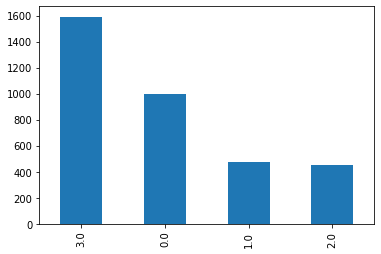

In [713]:
be.accuracy_group.value_counts().plot(kind="bar")

#### MERGING WITH BETA

In [714]:
features = be.join(qu,how="left").fillna(0)
features = features.copy().drop(columns="accuracy_group")
features.head()

,0.0,1.0,2.0,3.0,Activity,Assessment,Clip,Game,assesments_CC,assessments_MP,...,shroom_max,max_ceiling,low_score,median_score,no_actions,num_incorrect,tendency_avg_scorer,tendency_high_scorer,tendency_low_scorer,tendency_random_scorer
installation_id,,,,,,,,,,,,,,,,,,,,,
0006a69f,1.0,0.0,1.0,2.0,10.0,4.0,28.0,13.0,0.0,0.0,...,1.0,1.0,0.0,0.0,212.0,212.0,0.0,0.0,1.0,0.0
0006c192,1.0,0.0,0.0,1.0,8.0,2.0,30.0,6.0,0.0,1.0,...,0.0,1.0,0.0,0.0,140.0,140.0,0.0,0.0,1.0,0.0
00129856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001d0ed0,1.0,0.0,1.0,2.0,1.0,4.0,19.0,3.0,1.0,0.0,...,1.0,1.0,0.0,0.0,165.0,165.0,1.0,0.0,0.0,0.0
00225f67,0.0,0.0,0.0,0.0,3.0,0.0,10.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [715]:
features.shape

(3523, 52)

#### REMOVE NA_USERS ON TRAIN

In [722]:
na_users = list(features[features.max_ceiling.isna()].index)

In [723]:
features = features[~features.index.isin(na_users)]

In [724]:
# Data Frame with accuracy group, i.e., the "y" or target
y = pd.read_csv("last_assessments.csv")
y = y[["installation_id","accuracy_group"]].set_index("installation_id")

y = y[~y.index.isin(na_users)]

In [725]:
y.shape

(3523, 1)

In [726]:
print(f"Features Shape: {features.shape}")
print(f"y Shape: {y.shape}")

Features Shape: (3523, 52)
y Shape: (3523, 1)


In [727]:
y.accuracy_group.value_counts()

3.0    1590
0.0    1000
1.0     479
2.0     454
Name: accuracy_group, dtype: int64

### Scale

In [740]:
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(be),columns=be.columns).set_index(be.index)

In [741]:
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(features),columns=features.columns).set_index(features.index)

In [742]:
scaled_features.head()

,0.0,1.0,2.0,3.0,Activity,Assessment,Clip,Game,assesments_CC,assessments_MP,...,shroom_max,max_ceiling,low_score,median_score,no_actions,num_incorrect,tendency_avg_scorer,tendency_high_scorer,tendency_low_scorer,tendency_random_scorer
installation_id,,,,,,,,,,,,,,,,,,,,,
0006a69f,0.242308,-0.47812,0.768704,0.153026,0.475096,0.222541,0.437310,0.487777,-0.676356,-0.588786,...,1.464983,0.850926,-0.639071,-0.639071,0.292937,0.292937,-0.314992,-0.533254,1.940941,-0.479685
0006c192,0.242308,-0.47812,-0.492071,-0.276202,0.238053,-0.287385,0.525041,-0.074198,-0.676356,0.240600,...,-0.731858,0.850926,-0.639071,-0.639071,-0.056929,-0.056929,-0.314992,-0.533254,1.940941,-0.479685
00129856,-0.502589,-0.47812,-0.492071,-0.705429,-0.710121,-0.797310,-0.790924,-0.555890,-0.676356,-0.588786,...,-0.731858,-1.272253,-0.639071,-0.639071,-0.737223,-0.737223,-0.314992,-0.533254,-0.515214,-0.479685
001d0ed0,0.242308,-0.47812,0.768704,0.153026,-0.591599,0.222541,0.042521,-0.315044,-0.152087,-0.588786,...,1.464983,0.850926,-0.639071,-0.639071,0.064552,0.064552,3.174684,-0.533254,-0.515214,-0.479685
00225f67,-0.502589,-0.47812,-0.492071,-0.705429,-0.354556,-0.797310,-0.352269,-0.315044,-0.676356,-0.588786,...,-0.731858,-1.272253,-0.639071,-0.639071,-0.737223,-0.737223,-0.314992,-0.533254,-0.515214,-0.479685


In [743]:
scaled_features.columns

Index(['0.0', '1.0', '2.0', '3.0', 'Activity', 'Assessment', 'Clip', 'Game',
       'assesments_CC', 'assessments_MP', 'Assessments_TTC',
       'max_accuracy_group', 'median_accuracy_group', 'low_accuracy_group',
       'avg_no_actions', 'CRYSTALCAVES', 'MAGMAPEAK', 'NONE', 'TREETOPCITY',
       'activity_mins', 'assessment_mins', 'clip_mins', 'game_mins',
       'bird_med', 'cart_med', 'cauld_med', 'chest_med', 'shroom_med',
       'bird_mean', 'cart_mean', 'cauld_mean', 'chest_mean', 'shroom_mean',
       'bird_min', 'cart_min', 'cauld_min', 'chest_min', 'shroom_min',
       'bird_max', 'cart_max', 'cauld_max', 'chest_max', 'shroom_max',
       'max_ceiling', 'low_score', 'median_score', 'no_actions',
       'num_incorrect', 'tendency_avg_scorer', 'tendency_high_scorer',
       'tendency_low_scorer', 'tendency_random_scorer'],
      dtype='object')

In [744]:
df_feed = scaled_features.copy()

In [745]:
df_feed

,0.0,1.0,2.0,3.0,Activity,Assessment,Clip,Game,assesments_CC,assessments_MP,...,shroom_max,max_ceiling,low_score,median_score,no_actions,num_incorrect,tendency_avg_scorer,tendency_high_scorer,tendency_low_scorer,tendency_random_scorer
installation_id,,,,,,,,,,,,,,,,,,,,,
0006a69f,0.242308,-0.478120,0.768704,0.153026,0.475096,0.222541,0.437310,0.487777,-0.676356,-0.588786,...,1.464983,0.850926,-0.639071,-0.639071,0.292937,0.292937,-0.314992,-0.533254,1.940941,-0.479685
0006c192,0.242308,-0.478120,-0.492071,-0.276202,0.238053,-0.287385,0.525041,-0.074198,-0.676356,0.240600,...,-0.731858,0.850926,-0.639071,-0.639071,-0.056929,-0.056929,-0.314992,-0.533254,1.940941,-0.479685
00129856,-0.502589,-0.478120,-0.492071,-0.705429,-0.710121,-0.797310,-0.790924,-0.555890,-0.676356,-0.588786,...,-0.731858,-1.272253,-0.639071,-0.639071,-0.737223,-0.737223,-0.314992,-0.533254,-0.515214,-0.479685
001d0ed0,0.242308,-0.478120,0.768704,0.153026,-0.591599,0.222541,0.042521,-0.315044,-0.152087,-0.588786,...,1.464983,0.850926,-0.639071,-0.639071,0.064552,0.064552,3.174684,-0.533254,-0.515214,-0.479685
00225f67,-0.502589,-0.478120,-0.492071,-0.705429,-0.354556,-0.797310,-0.352269,-0.315044,-0.676356,-0.588786,...,-0.731858,-1.272253,-0.639071,-0.639071,-0.737223,-0.737223,-0.314992,-0.533254,-0.515214,-0.479685
00279ac5,-0.502589,-0.478120,-0.492071,-0.705429,0.475096,-0.797310,0.130252,0.327213,-0.676356,-0.588786,...,-0.731858,-1.272253,-0.639071,-0.639071,-0.737223,-0.737223,-0.314992,-0.533254,-0.515214,-0.479685
002db7e3,0.987205,0.663858,2.029478,0.582253,1.067705,1.242391,0.919831,0.327213,0.896451,0.240600,...,1.464983,0.850926,-0.639071,-0.639071,1.225912,1.225912,-0.314992,-0.533254,-0.515214,2.084701
003372b0,0.242308,-0.478120,0.768704,0.582253,0.238053,0.477503,0.393445,0.327213,0.896451,-0.588786,...,1.464983,0.850926,-0.639071,-0.639071,0.239485,0.239485,-0.314992,-0.533254,1.940941,-0.479685
004c2091,0.242308,-0.478120,-0.492071,0.153026,0.119531,-0.032422,0.130252,-0.475608,-0.676356,1.069986,...,-0.731858,0.850926,-0.639071,-0.639071,-0.372780,-0.372780,-0.314992,1.875278,-0.515214,-0.479685


### Train-Test Split

In [746]:
X_train, X_test, y_train, y_test = train_test_split(df_feed,y, test_size=0.3, stratify=y["accuracy_group"],random_state=123)

In [747]:
y_train.accuracy_group.value_counts()

3.0    1113
0.0     700
1.0     335
2.0     318
Name: accuracy_group, dtype: int64

In [748]:
X_test.shape

(1057, 52)

### Feature Engineering

In [749]:
lasso = LassoCV()
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [750]:
print(f"Best alpha using built-in LassoCV: {lasso.alpha_}")
print(f"Best score using built-in LassoCV: {lasso.score(X_train,y_train)}")

Best alpha using built-in LassoCV: 0.010510481371265222
Best score using built-in LassoCV: 0.10346126209204409


In [751]:
coef = pd.DataFrame(lasso.coef_, index = X_train.columns).rename(columns={0:"feature_weights"}).sort_values(by="feature_weights",ascending=False)

In [752]:
coef.head()

,feature_weights
MAGMAPEAK,0.143715
bird_max,0.105136
max_ceiling,0.104424
cauld_med,0.061297
chest_max,0.051451


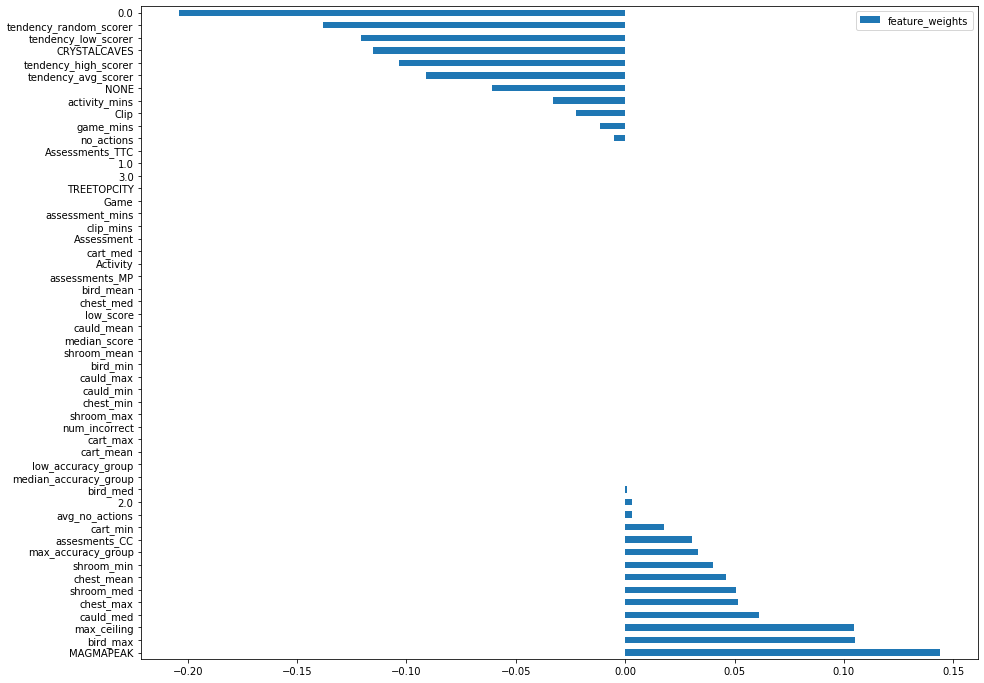

In [753]:
coef.plot(kind="barh",figsize=(15,12))

### Keep all non-zero features

In [754]:
weighted_coef = coef[coef.feature_weights != 0]

In [755]:
#see if all zero-value features are removed
weighted_coef.describe()

,feature_weights
count,27.000000
mean,-0.007903
std,0.080662
min,-0.204145
25%,-0.046846
50%,0.000950
75%,0.043290
max,0.143715


In [756]:
weighted_coef_list = list(weighted_coef.index)

In [757]:
X_train.head()

,0.0,1.0,2.0,3.0,Activity,Assessment,Clip,Game,assesments_CC,assessments_MP,...,shroom_max,max_ceiling,low_score,median_score,no_actions,num_incorrect,tendency_avg_scorer,tendency_high_scorer,tendency_low_scorer,tendency_random_scorer
installation_id,,,,,,,,,,,,,,,,,,,,,
b4373bbc,-0.502589,-0.478120,-0.492071,-0.705429,-0.591599,-0.797310,-0.703193,-0.475608,-0.676356,-0.588786,...,-0.731858,-1.272253,-0.639071,-0.639071,-0.737223,-0.737223,-0.314992,-0.533254,-0.515214,-0.479685
996c185b,0.242308,2.947814,3.290252,3.157616,2.371444,3.282092,1.709410,0.568059,2.469258,1.899372,...,1.464983,0.850926,-0.639071,-0.639071,2.265790,2.265790,-0.314992,-0.533254,1.940941,-0.479685
49ee3af8,-0.502589,-0.478120,-0.492071,-0.705429,-0.710121,-0.797310,-0.703193,-0.555890,-0.676356,-0.588786,...,-0.731858,-1.272253,-0.639071,-0.639071,-0.737223,-0.737223,-0.314992,-0.533254,-0.515214,-0.479685
f9436b97,0.987205,0.663858,-0.492071,0.153026,0.593618,0.477503,-0.001345,0.006084,0.372182,1.899372,...,-0.731858,0.850926,-0.639071,-0.639071,0.132582,0.132582,-0.314992,-0.533254,-0.515214,2.084701
8f4c404c,-0.502589,-0.478120,-0.492071,-0.276202,-0.473078,-0.542347,-0.790924,-0.315044,-0.676356,0.240600,...,-0.731858,0.850926,2.019510,2.019510,-0.567150,-0.567150,-0.314992,1.875278,-0.515214,-0.479685


In [758]:
X_train = X_train[weighted_coef_list]
X_test = X_test[weighted_coef_list]

In [759]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (2466, 27)
X_test shape: (1057, 27)


---
## VI. MODELING

### Random Forest

Create Random Forest object.  
Fit Train data.

In [760]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=600)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=600,
                       verbose=0, warm_start=False)

Look at how the algorithm use features, that is, check feature importance.

In [761]:
rf_features = pd.DataFrame([rf.feature_importances_],columns = X_train.columns).T.rename(columns = {0: 'feature_importance'}).sort_values(by='feature_importance', ascending=False)

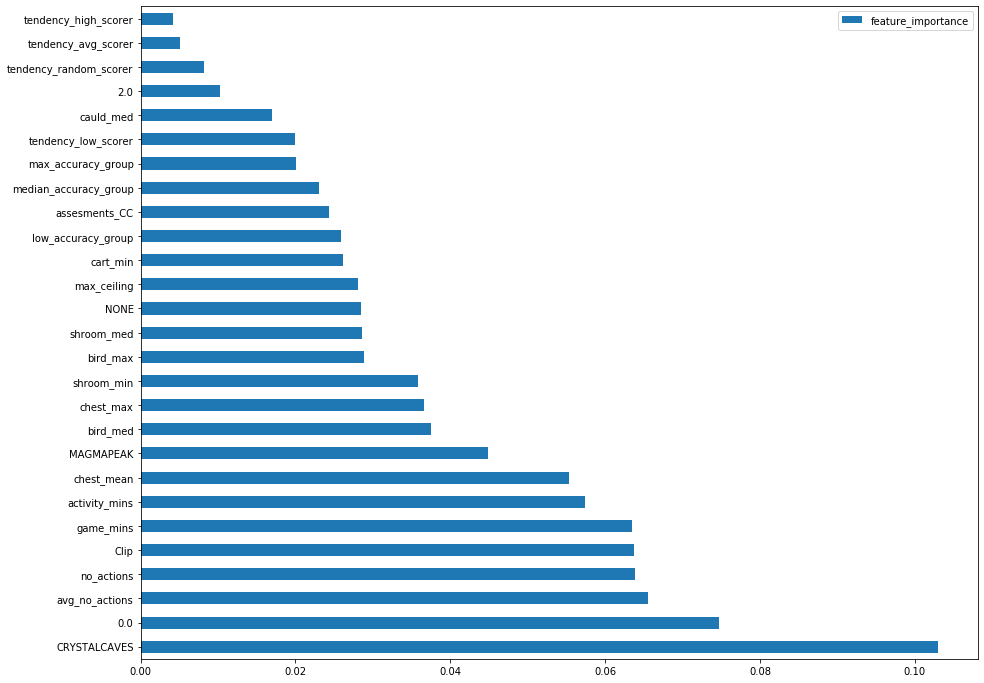

In [762]:
rf_features.plot(kind="barh",figsize=(15,12))

In [763]:
y_pred = pd.DataFrame(rf.predict(X_train),index = X_train.index)
y_pred_test = pd.DataFrame(rf.predict(X_test),index = X_test.index)

In [764]:
y_train.head()

,accuracy_group
installation_id,
b4373bbc,2.0
996c185b,3.0
49ee3af8,3.0
f9436b97,0.0
8f4c404c,3.0


In [765]:
predictions = y_train.copy().rename(columns={"accuracy_group":"actual_y"})
predictions[["predicted_y"]] = y_pred

In [766]:
predictions.head()

,actual_y,predicted_y
installation_id,,
b4373bbc,2.0,3.0
996c185b,3.0,3.0
49ee3af8,3.0,3.0
f9436b97,0.0,3.0
8f4c404c,3.0,3.0


#### EVALUATION: RANDOM FOREST

In [767]:
print(f"RF Score for Train: {rf.score(X_train, y_train)}")
print(f"RF Score for Test: {rf.score(X_test, y_test)}")

RF Score for Train: 0.5393349553933495
RF Score for Test: 0.4910122989593188


In [768]:
confusion_matrix(predictions.actual_y, predictions.predicted_y)

array([[ 290,    0,    0,  410],
       [  42,    6,    0,  287],
       [  33,    0,    2,  283],
       [  81,    0,    0, 1032]])

In [769]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

         0.0       0.50      0.34      0.40       300
         1.0       0.00      0.00      0.00       144
         2.0       0.00      0.00      0.00       136
         3.0       0.49      0.88      0.63       477

    accuracy                           0.49      1057
   macro avg       0.25      0.30      0.26      1057
weighted avg       0.36      0.49      0.40      1057



### Logistic Regression

---

# Checking - to be removed

In [1043]:
from scipy import stats

#### DF THAT HAS TENDENCIES PER INSTALLATION ID

In [972]:
assessment.head()

,Unnamed: 0,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,num_correct,num_incorrect,accuracy,accuracy_group,date,hour,weekday
647,647,3bfd1a65,901acc108f55a5a1,2019-08-06 05:22:01.344000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,1.0,0.0,1.0,3.0,2019-08-06,5,Tuesday
648,648,db02c830,901acc108f55a5a1,2019-08-06 05:22:01.400000+00:00,"{""event_count"":2,""game_time"":37,""event_code"":2...",0006a69f,2,2025,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,1.0,0.0,1.0,3.0,2019-08-06,5,Tuesday
649,649,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:01.403000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,3,3010,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,1.0,0.0,1.0,3.0,2019-08-06,5,Tuesday
650,650,a52b92d5,901acc108f55a5a1,2019-08-06 05:22:05.242000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,4,3110,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,1.0,0.0,1.0,3.0,2019-08-06,5,Tuesday
651,651,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:05.244000+00:00,"{""description"":""To pick a mushroom, pull it ou...",0006a69f,5,3010,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,1.0,0.0,1.0,3.0,2019-08-06,5,Tuesday


In [1047]:
# a_counts = assessment.groupby(["installation_id","game_session"]).agg(stats.mode)[["accuracy_group"]]
# # a_counts = a_counts.drop_duplicates(subset="installation_id",keep="first")

In [1045]:
a_counts = assessment.groupby(["installation_id","game_session"]).median()[["accuracy_group"]].reset_index().groupby(["installation_id"]).median()[["accuracy_group"]].reset_index()
# a_counts = a_counts.drop_duplicates(subset="installation_id",keep="first")

In [1048]:
a_counts.head()

accuracy_group
installation_id game_session                   
0006a69f        6bdf9623adc94d89  ([3.0], [35])
                77b8ee947eb84b4e  ([0.0], [87])
                901acc108f55a5a1  ([3.0], [48])
                9501794defd84e4d  ([2.0], [42])
0006c192        197a373a77101924  ([3.0], [24])

In [1009]:
a_counts["tendency"

Index(['installation_id', 'accuracy_group', 'game_session'], dtype='object')

In [1013]:
a_counts = a_counts.drop_duplicates(subset="installation_id",keep="first")

In [1014]:
a_counts =

,installation_id,accuracy_group,game_session
0,ffeb0b1b,0.0,1
2,ffc90c32,3.0,4
4,ff9715db,3.0,5
8,ff9305d7,0.0,2
10,ff90db99,3.0,5


In [ ]:
a_counts[]

In [967]:
assessment.groupby(["installation_id","accuracy_group","game_session"])[["game_session"]].sum()

game_session
installation_id accuracy_group game_session                                                       
0006a69f        0.0            77b8ee947eb84b4e  77b8ee947eb84b4e77b8ee947eb84b4e77b8ee947eb84b...
                2.0            9501794defd84e4d  9501794defd84e4d9501794defd84e4d9501794defd84e...
                3.0            6bdf9623adc94d89  6bdf9623adc94d896bdf9623adc94d896bdf9623adc94d...
                               901acc108f55a5a1  901acc108f55a5a1901acc108f55a5a1901acc108f55a5...
0006c192        0.0            b2297d292892745a  b2297d292892745ab2297d292892745ab2297d29289274...
                3.0            197a373a77101924  197a373a77101924197a373a77101924197a373a771019...
001d0ed0        0.0            7b536271e99518f0  7b536271e99518f07b536271e99518f07b536271e99518...
                2.0            c046a858e7c8bf03  c046a858e7c8bf03c046a858e7c8bf03c046a858e7c8bf...
                3.0            9480b026e3e7d371  9480b026e3e7d3719480b026e3e7d3719480b026e3e7d3...
                               dc6bc0284039c9fb  dc6bc0284039c9fbdc6bc0284039c9fbdc6bc0284039c9...
002db7e3        0.0            67f9274eb736ab3f  67f9274eb736ab3f67f9274eb736ab3f67f9274eb736ab...
                               f50104895c55045f  f50104895c55045ff50104895c55045ff50104895c5504...
                1.0            cace4c493ac347e3  cace4c493ac347e3cace4c493ac347e3cace4c493ac347...
                2.0            03e73cfb40d8d204  03e73cfb40d8d20403e73cfb40d8d20403e73cfb40d8d2...
                               8f50f2fd987cade4  8f50f2fd987cade48f50f2fd987cade48f50f2fd987cad...
                3.0            113a557b60770369  113a557b60770369113a557b60770369113a557b607703...
                               1c48bdca76efc7b0  1c48bdca76efc7b01c48bdca76efc7b01c48bdca76efc7...
                               470a1bd6b99152a7  470a1bd6b99152a7470a1bd6b99152a7470a1bd6b99152...
003372b0        0.0            4649b29840d5b0f1  4649b29840d5b0f14649b29840d5b0f14649b29840d5b0...
                2.0            28113cd58d865372  28113cd58d86537228113cd58d86537228113cd58d8653...
                3.0            0adc585fb4f48458  0adc585fb4f484580adc585fb4f484580adc585fb4f484...
                               3beae5a17e0b26f6  3beae5a17e0b26f63beae5a17e0b26f63beae5a17e0b26...
                               631971b2efa19b8d  631971b2efa19b8d631971b2efa19b8d631971b2efa19b...
004c2091        0.0            4e446ee715d1bd94  4e446ee715d1bd944e446ee715d1bd944e446ee715d1bd...
                3.0            3a50778205e34531  3a50778205e345313a50778205e345313a50778205e345...
                               ae5de691ea2252f1  ae5de691ea2252f1ae5de691ea2252f1ae5de691ea2252...
00634433        3.0            1454d273262f61e3  1454d273262f61e31454d273262f61e31454d273262f61...
                               440633fe3ef55b90  440633fe3ef55b90440633fe3ef55b90440633fe3ef55b...
00667b88        3.0            a01b01d1e22d0446  a01b01d1e22d0446a01b01d1e22d0446a01b01d1e22d04...
00691033        0.0            01d44d1b32c3da7f  01d44d1b32c3da7f01d44d1b32c3da7f01d44d1b32c3da...
...                                                                                            ...
ff3e1e35        3.0            75b8b0117b4bba64  75b8b0117b4bba6475b8b0117b4bba6475b8b0117b4bba...
                               83bd28d8462140f2  83bd28d8462140f283bd28d8462140f283bd28d8462140...
                               905026357aedc8d1  905026357aedc8d1905026357aedc8d1905026357aedc8...
                               9f389226fbc40b2c  9f389226fbc40b2c9f389226fbc40b2c9f389226fbc40b...
                               b5dd76c4004c35b9  b5dd76c4004c35b9b5dd76c4004c35b9b5dd76c4004c35...
ff882868        1.0            174c2949b38d869c  174c2949b38d869c174c2949b38d869c174c2949b38d86...
ff90db99        1.0            2ba76e51acd87d41  2ba76e51acd87d412ba76e51acd87d412ba76e51acd87d...
                3.0            0b2c8152e8a59f3e  0b2c8152e8a59f3e0b2c8152e8a59f3e0b2c8152e8a59f...
                           

#### HOW MUCH ARE THEY PLAYING AROUND BEFORE THEY HIT "DONE"/ATTEMPT

In [885]:
assessment_sub = assessment[assessment.accuracy_group.isin([1,2])]

In [947]:
assessment_sub.sample()

,Unnamed: 0,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,num_correct,num_incorrect,accuracy,accuracy_group,date,hour,weekday
3873538,5702555,7da34a02,995c3aa2c3bd8399,2019-09-01 05:47:10.947000+00:00,"{""coordinates"":{""x"":805,""y"":559,""stage_width"":...",baedce19,46,4070,40312,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,1.0,4.0,0.2,1.0,2019-09-01,5,Sunday


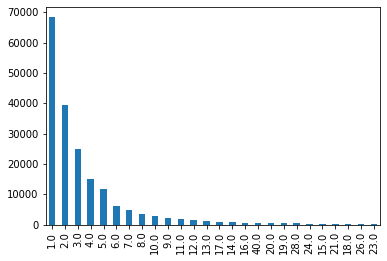

In [940]:
assessment_sub["num_incorrect"].value_counts().plot(kind="bar")

In [959]:
assessment_sub[["event_id","title"]]

,event_id,title
2142,3bfd1a65,Mushroom Sorter (Assessment)
2143,db02c830,Mushroom Sorter (Assessment)
2144,a1e4395d,Mushroom Sorter (Assessment)
2145,28ed704e,Mushroom Sorter (Assessment)
2146,a52b92d5,Mushroom Sorter (Assessment)
2147,9d29771f,Mushroom Sorter (Assessment)
2148,c74f40cd,Mushroom Sorter (Assessment)
2149,28ed704e,Mushroom Sorter (Assessment)
2150,9d29771f,Mushroom Sorter (Assessment)
2151,c74f40cd,Mushroom Sorter (Assessment)


In [957]:
assessment_sub.groupby(["installation_id","game_session","event_id","accuracy"]).count()[["num_incorrect"]]

num_incorrect
installation_id game_session     event_id accuracy               
0006a69f        9501794defd84e4d 160654fd 0.500000              1
                                 25fa8af4 0.500000              2
                                 28ed704e 0.500000              3
                                 3bfd1a65 0.500000              1
                                 3dfd4aa4 0.500000              1
                                 5f0eb72c 0.500000              6
                                 6c930e6e 0.500000              1
                                 7da34a02 0.500000              1
                                 83c6c409 0.500000              1
                                 88d4a5be 0.500000              1
                                 9d29771f 0.500000              4
                                 a1e4395d 0.500000              3
                                 a52b92d5 0.500000              3
                                 a5be6304 0.500000              1
                                 c7128948 0.500000              1
                                 c74f40cd 0.500000              4
                                 db02c830 0.500000              1
                                 fbaf3456 0.500000              7
001d0ed0        c046a858e7c8bf03 0d18d96c 0.500000              1
                                 160654fd 0.500000              1
                                 25fa8af4 0.500000              2
                                 28ed704e 0.500000              3
                                 3bfd1a65 0.500000              1
                                 3dfd4aa4 0.500000              1
                                 5f0eb72c 0.500000              4
                                 6c930e6e 0.500000              1
                                 7da34a02 0.500000             25
                                 83c6c409 0.500000              1
                                 88d4a5be 0.500000              1
                                 9d29771f 0.500000              4
...                                                           ...
ffc90c32        98e91ee8ce88793b 3dfd4aa4 0.333333              1
                                 5f0eb72c 0.333333              7
                                 6c930e6e 0.333333              1
                                 7da34a02 0.333333             18
                                 83c6c409 0.333333              1
                                 88d4a5be 0.333333              2
                                 9d29771f 0.333333              4
                                 a1e4395d 0.333333              3
                                 a52b92d5 0.333333              3
                                 a5be6304 0.333333              1
                                 c74f40cd 0.333333              4
                                 db02c830 0.333333              1
                                 fbaf3456 0.333333              7
ffeb0b1b        dadd1a4d8ac68ab0 04df9b66 0.333333              3
                                 28520915 0.333333              2
                                 2b058fe3 0.333333              1
                                 2dcad279 0.333333              8
                                 30614231 0.333333              7
                                 37ee8496 0.333333             15
                                 392e14df 0.333333              3
                                 3edf6747 0.333333              2
                                 3ee399c3 0.333333             20
                                 5290eab1 0.333333              3
                                 532a2afb 0.333333              2
                                 5348fd84 0.333333              6
                                 90d848e0 0.333333              1
                                 91561152 0.333333              2
                                 923afab1 0.333333              8
                          

In [944]:
assessment_sub.shape

(188757, 19)

In [946]:
assessment_sub.accuracy_group.value_counts()

1.0    120465
2.0     68292
Name: accuracy_group, dtype: int64

In [945]:
assessment.num_correct.value_counts()

1.0    386638
0.0    147856
Name: num_correct, dtype: int64

In [950]:
assessment[assessment.installation_id == "baedce19"]

,Unnamed: 0,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,num_correct,num_incorrect,accuracy,accuracy_group,date,hour,weekday
3870532,5699478,90d848e0,ad849e5c3bc2a43d,2019-08-30 04:28:08.686000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",baedce19,1,2000,0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1.0,12.0,0.076923,1.0,2019-08-30,4,Friday
3870533,5699479,923afab1,ad849e5c3bc2a43d,2019-08-30 04:28:08.993000+00:00,"{""description"":""Put the right sized bucket und...",baedce19,2,3010,387,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1.0,12.0,0.076923,1.0,2019-08-30,4,Friday
3870534,5699480,532a2afb,ad849e5c3bc2a43d,2019-08-30 04:28:08.993000+00:00,"{""buckets"":[2,3,1],""target_bucket"":0,""mode"":""p...",baedce19,3,2020,387,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1.0,12.0,0.076923,1.0,2019-08-30,4,Friday
3870535,5699481,2dcad279,ad849e5c3bc2a43d,2019-08-30 04:28:13.634000+00:00,"{""description"":""Put the right sized bucket und...",baedce19,4,3110,5052,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1.0,12.0,0.076923,1.0,2019-08-30,4,Friday
3870536,5699482,3ee399c3,ad849e5c3bc2a43d,2019-08-30 04:28:13.835000+00:00,"{""coordinates"":{""x"":350,""y"":163,""stage_width"":...",baedce19,5,4070,5236,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1.0,12.0,0.076923,1.0,2019-08-30,4,Friday
3870537,5699483,3ee399c3,ad849e5c3bc2a43d,2019-08-30 04:28:14.279000+00:00,"{""coordinates"":{""x"":284,""y"":157,""stage_width"":...",baedce19,6,4070,5686,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1.0,12.0,0.076923,1.0,2019-08-30,4,Friday
3870538,5699484,3ee399c3,ad849e5c3bc2a43d,2019-08-30 04:28:14.914000+00:00,"{""coordinates"":{""x"":301,""y"":165,""stage_width"":...",baedce19,7,4070,6319,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1.0,12.0,0.076923,1.0,2019-08-30,4,Friday
3870539,5699485,3ee399c3,ad849e5c3bc2a43d,2019-08-30 04:28:16.276000+00:00,"{""coordinates"":{""x"":265,""y"":174,""stage_width"":...",baedce19,8,4070,7686,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1.0,12.0,0.076923,1.0,2019-08-30,4,Friday
3870540,5699486,3ee399c3,ad849e5c3bc2a43d,2019-08-30 04:28:16.911000+00:00,"{""coordinates"":{""x"":320,""y"":180,""stage_width"":...",baedce19,9,4070,8319,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1.0,12.0,0.076923,1.0,2019-08-30,4,Friday
3870541,5699487,3ee399c3,ad849e5c3bc2a43d,2019-08-30 04:28:17.381000+00:00,"{""coordinates"":{""x"":362,""y"":119,""stage_width"":...",baedce19,10,4070,8786,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,1.0,12.0,0.076923,1.0,2019-08-30,4,Friday


In [ ]:
assessment

---

In [856]:
subset_12 = features.join(y)

In [857]:
subset_12.head()

,0.0,1.0,2.0,3.0,Activity,Assessment,Clip,Game,assesments_CC,assessments_MP,...,max_ceiling,low_score,median_score,no_actions,num_incorrect,tendency_avg_scorer,tendency_high_scorer,tendency_low_scorer,tendency_random_scorer,accuracy_group
installation_id,,,,,,,,,,,,,,,,,,,,,
0006a69f,1.0,0.0,1.0,2.0,10.0,4.0,28.0,13.0,0.0,0.0,...,1.0,0.0,0.0,212.0,212.0,0.0,0.0,1.0,0.0,3.0
0006c192,1.0,0.0,0.0,1.0,8.0,2.0,30.0,6.0,0.0,1.0,...,1.0,0.0,0.0,140.0,140.0,0.0,0.0,1.0,0.0,2.0
00129856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
001d0ed0,1.0,0.0,1.0,2.0,1.0,4.0,19.0,3.0,1.0,0.0,...,1.0,0.0,0.0,165.0,165.0,1.0,0.0,0.0,0.0,0.0
00225f67,0.0,0.0,0.0,0.0,3.0,0.0,10.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [858]:
subset_12 = subset_12[subset_12.accuracy_group.isin([1,2])]
subset_12.accuracy_group = np.where(subset_12.accuracy_group == 1, "one","two")

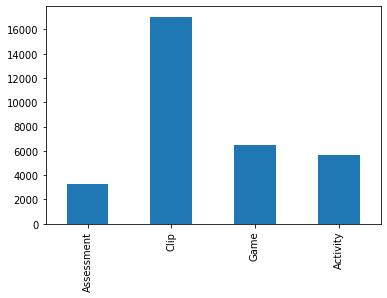

In [860]:
subset_12[["Assessment","Clip","Game","Activity"]].sum().plot(kind="bar")

---

In [863]:
X_subset_12 = subset_12.drop(columns="accuracy_group")

In [864]:
y_subset_12 = subset_12[["accuracy_group"]]

In [865]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=600)

rf.fit(X_subset_12, y_subset_12)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=600,
                       verbose=0, warm_start=False)

In [866]:
subset12_features = pd.DataFrame([rf.feature_importances_],columns = X_subset_12.columns).T.rename(columns = {0: 'feature_importance'}).sort_values(by='feature_importance', ascending=False)

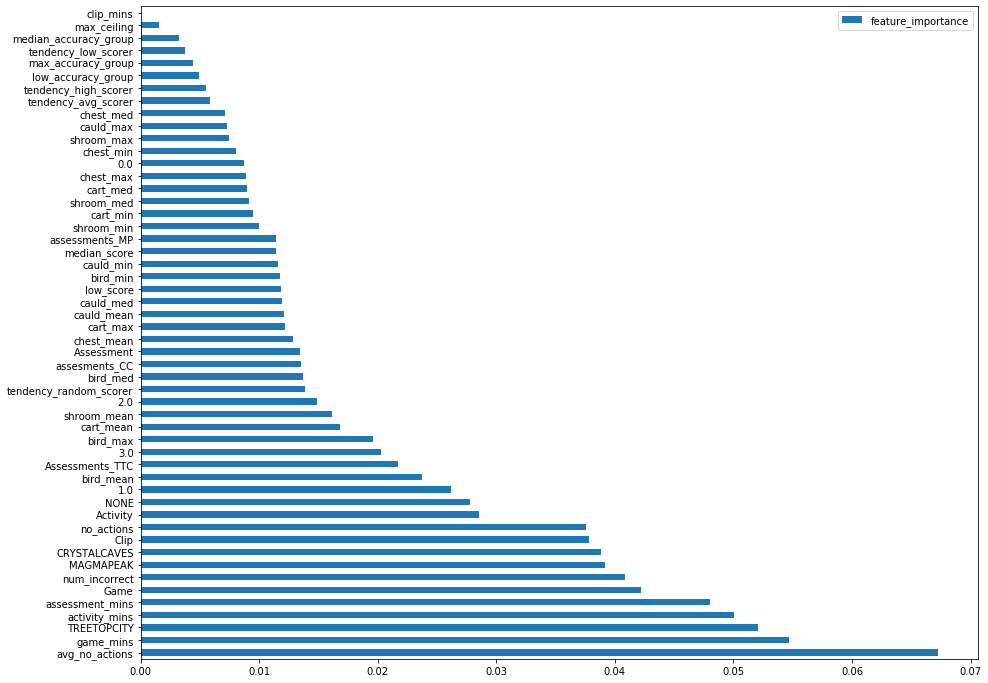

In [867]:
subset12_features.plot(kind="barh",figsize=(15,12))

In [868]:
print(f"RF Score for Train: {rf.score(X_subset_12, y_subset_12)}")

RF Score for Train: 0.8038585209003215
